In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from file_utils import load_dataframes
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
sns.set_theme()

dataset_dir = 'data'

In [3]:
items = pd.read_csv(f'{dataset_dir}/items.csv', na_values='unknown',
                        dtype={'item_id': 'Int64', 'alley_id': 'Int64', 'category': 'Int64'})
items.drop(columns='Unnamed: 0', inplace=True)
items.dropna(subset=['item_id'], inplace=True)
# items.set_index(['item_id'], inplace=True)

In [4]:
categories = pd.read_csv('data/categories.csv', index_col='category_id')
categories.drop(columns='Unnamed: 0', inplace=True)

In [5]:
alley_inventory = pd.read_csv('data/alley_inventory.csv', index_col='alley_id')

In [6]:
transaction_items__prior = pd.read_csv('data/transaction_items__prior.csv', na_values='unknown',
                                       dtype={'transaction_id': 'Int64', 'item_id': 'Int64',
                                              'add_to_cart_order': 'Int64', 'previous_bought': 'Int64'})
transaction_items__prior.drop(columns=['Unnamed: 0'], inplace=True)
transaction_items__prior.dropna(subset=['transaction_id', 'item_id'], inplace=True)

In [7]:
transactions = pd.read_csv('data/transactions.csv', na_values='unknown',
                               dtype={'transaction_id': 'Int64', 'customer_id': 'Int64', 'transaction_number': 'Int64',
                                      'day_of_week': 'category', 'time_of_day': 'Int64',
                                      'days_since_prior_order': 'Int64'})

transactions.drop(columns='Unnamed: 0', inplace=True)
transactions.dropna(subset=['transaction_id'], inplace=True)
transactions.set_index(['transaction_id'], inplace=True)

In [8]:
items.info()
items.head()

<class 'pandas.core.frame.DataFrame'>
Index: 47616 entries, 0 to 49146
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_id    47616 non-null  Int64 
 1   item_name  46130 non-null  object
 2   alley_id   46159 non-null  Int64 
 3   category   46138 non-null  Int64 
dtypes: Int64(3), object(1)
memory usage: 2.0+ MB


,item_id,item_name,alley_id,category
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
categories.info()
categories.head()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 1 to 21
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  21 non-null     object
dtypes: object(1)
memory usage: 336.0+ bytes


,category
category_id,
1,frozen
2,other
3,bakery
4,produce
5,alcohol


In [10]:
items_categories = pd.merge(items, categories, left_on='category', right_on='category_id', how='left')
items_categories = pd.merge(items_categories, alley_inventory, left_on='alley_id', right_on='alley_id', how='left')
items_categories.drop(columns=['category_x', 'alley_id'], inplace=True)
items_categories.rename(columns={'category_y': 'category'}, inplace=True)

In [11]:
items_categories.head()

,item_id,item_name,category,alley
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes
1,2,All-Seasons Salt,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals
4,5,Green Chile Anytime Sauce,pantry,marinades meat preparation


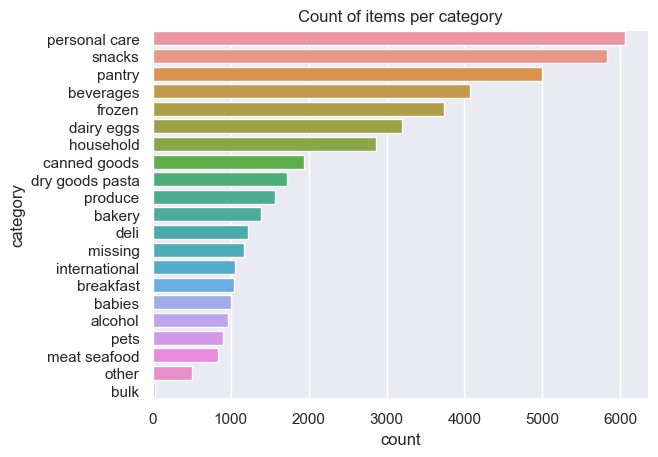

In [12]:
# countplot of categories
sns.countplot(y='category', data=items_categories, order=items_categories['category'].value_counts().index)
plt.title('Count of items per category')
plt.show()

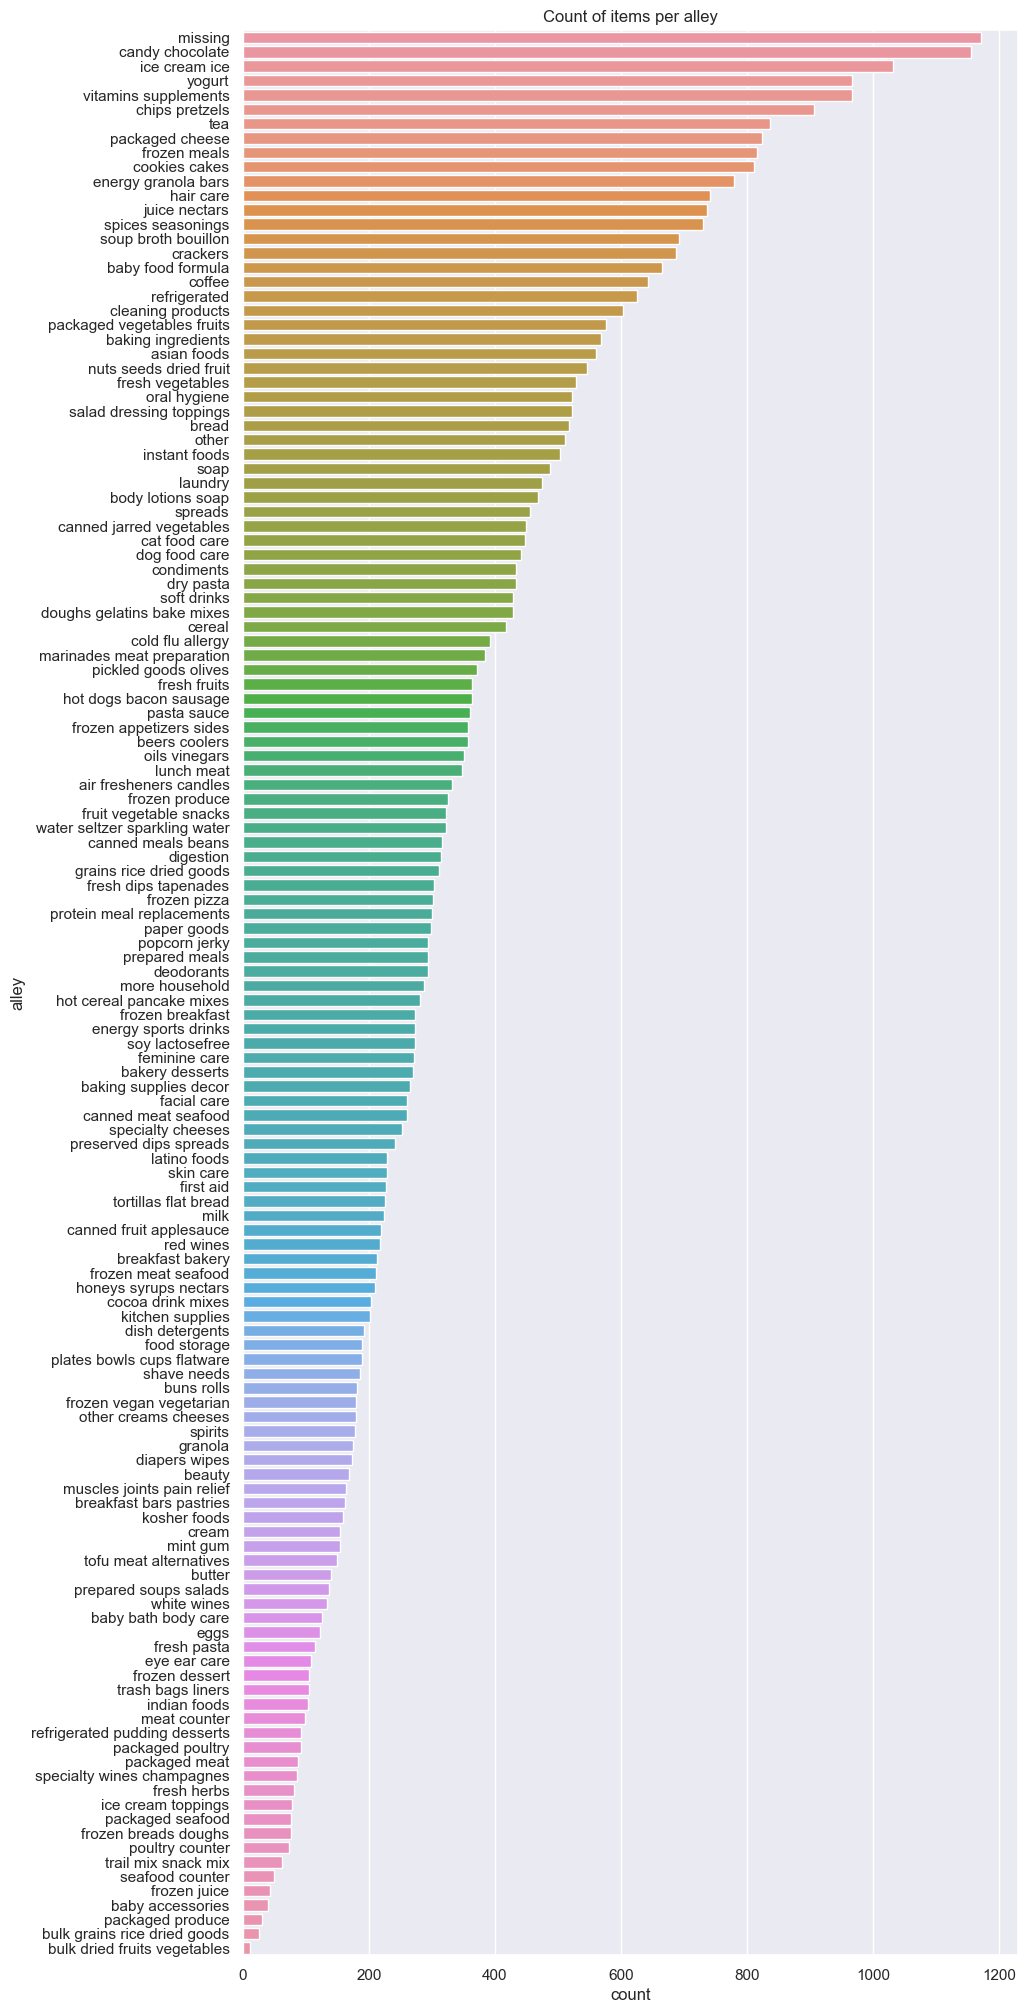

In [13]:
plt.figure(figsize=(10, 25))
sns.countplot(y='alley', data=items_categories, order=items_categories['alley'].value_counts().index)
plt.title('Count of items per alley')
plt.show()

In [14]:
transaction_items__prior.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30074126 entries, 0 to 32076244
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   transaction_id     Int64
 1   item_id            Int64
 2   add_to_cart_order  Int64
 3   previous_bought    Int64
dtypes: Int64(4)
memory usage: 1.2 GB


In [15]:
transaction_items = pd.merge(transaction_items__prior, items_categories, on='item_id')
transaction_items['quantity'] = 1

In [16]:
transaction_items.head()

,transaction_id,item_id,add_to_cart_order,previous_bought,item_name,category,alley,quantity
0,2,33120,1,1,Organic Egg Whites,dairy eggs,eggs,1
1,26,33120,5,0,Organic Egg Whites,dairy eggs,eggs,1
2,120,33120,13,0,Organic Egg Whites,dairy eggs,eggs,1
3,327,33120,5,1,Organic Egg Whites,dairy eggs,eggs,1
4,390,33120,28,1,Organic Egg Whites,dairy eggs,eggs,1


In [17]:
transactions__prior = transactions[transactions['eval_set'] == 'prior']

In [18]:
transaction_items = pd.merge(transaction_items, transactions__prior, on='transaction_id')

In [19]:
transaction_items

,transaction_id,item_id,add_to_cart_order,previous_bought,item_name,category,alley,quantity,customer_id,eval_set,transaction_number,day_of_week,time_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,dairy eggs,eggs,1,202279,prior,3,5.0,9,8
1,2,45918,4,1,Coconut Butter,pantry,oils vinegars,1,202279,prior,3,5.0,9,8
2,2,30035,5,0,Natural Sweetener,pantry,baking ingredients,1,202279,prior,3,5.0,9,8
3,2,17794,6,1,Carrots,produce,fresh vegetables,1,202279,prior,3,5.0,9,8
4,2,40141,7,1,Original Unflavored Gelatine Mix,pantry,doughs gelatins bake mixes,1,202279,prior,3,5.0,9,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26745799,1913368,43384,2,0,Bulgur & Soft Alfalfa,dry goods pasta,NaN,1,85396,prior,7,1.0,1,2
26745800,2493848,26565,1,0,Super Glue 2 Pack,household,more household,1,117101,prior,64,3.0,20,1
26745801,2666238,31530,1,0,Disinfecting Toilet Bowl Cleaner,household,cleaning products,1,51836,prior,12,0.0,18,0
26745802,2770035,39759,1,0,"Indoor & Outdoor Allergies, Allergy & Congesti...",personal care,cold flu allergy,1,37237,prior,50,6.0,16,2


In [20]:
total_bought = transaction_items.groupby('item_id')['quantity'].count().sort_values(ascending=False)
items_categories = pd.merge(items_categories, total_bought, on='item_id')

In [21]:
total_reordered = transaction_items.groupby('item_id')['previous_bought'].sum().sort_values(ascending=False)
total_reordered.rename('total_reordered', inplace=True)
items_categories = pd.merge(items_categories, total_reordered, on='item_id')
items_categories['reorder_ratio'] = items_categories['total_reordered'] / items_categories['quantity']

In [22]:
items_categories

,item_id,item_name,category,alley,quantity,total_reordered,reorder_ratio
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes,1579,944,0.597847
1,2,All-Seasons Salt,pantry,spices seasonings,76,9,0.118421
2,3,Robust Golden Unsweetened Oolong Tea,beverages,tea,229,158,0.689956
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals,279,116,0.415771
4,5,Green Chile Anytime Sauce,pantry,marinades meat preparation,13,8,0.615385
...,...,...,...,...,...,...,...
47571,49684,"Vodka, Triple Distilled, Twist of Vanilla",alcohol,spirits,7,1,0.142857
47572,49685,En Croute Roast Hazelnut Cranberry,frozen,frozen vegan vegetarian,39,5,0.128205
47573,49686,Artisan Baguette,bakery,bread,103,68,0.660194
47574,49687,Smartblend Healthy Metabolism Dry Cat Food,pets,cat food care,12,5,0.416667


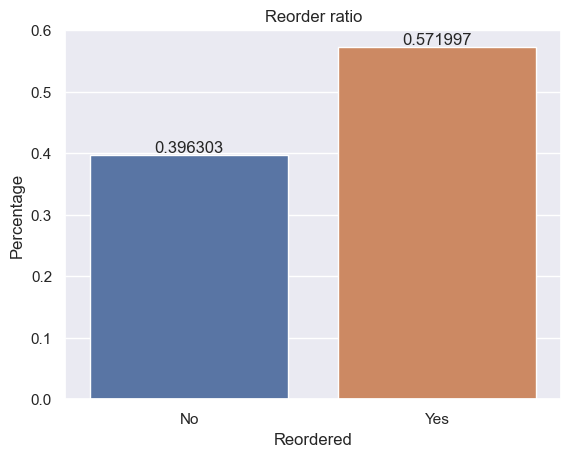

In [23]:
total_orders = transaction_items.shape[0]
reorder_ratio = transaction_items['previous_bought'].value_counts()/total_orders
ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values)
ax.set(xlabel='Reordered', ylabel='Percentage')
ax.set_xticklabels(['No', 'Yes'])
ax.bar_label(ax.containers[0])
plt.title('Reorder ratio')
plt.show()

In [24]:
print(f'Total orders: {total_orders}')
print(f'Total reordered products: {transaction_items["previous_bought"].sum()}')
print(f'Reorder ratio: {transaction_items["previous_bought"].sum()/total_orders}')

Total orders: 26745804
Total reordered products: 15298528
Reorder ratio: 0.5719973121765194


In [25]:
# products that have been bought more than 10 times but never reordered
never_reordered_items =  items_categories[(items_categories['quantity'] > 10) & (items_categories['total_reordered'] == 0)]

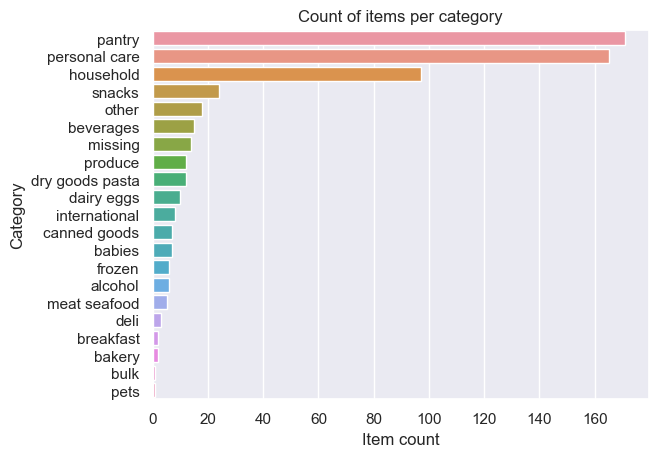

In [26]:
ax = sns.countplot(y='category', data=never_reordered_items, order=never_reordered_items['category'].value_counts().index)
plt.title('Count of items per category')
ax.set(xlabel='Item count', ylabel='Category')
plt.show()

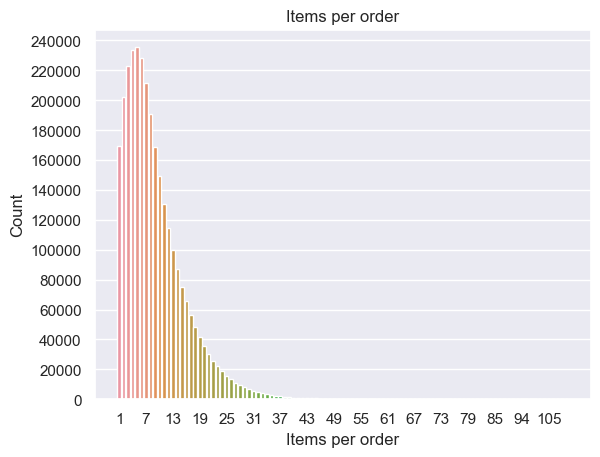

In [27]:
items_per_order = transaction_items.groupby('transaction_id', as_index=False)['item_id'].count()
items_per_order.rename(columns={'item_id': 'items_per_order'}, inplace=True)
ax = sns.countplot(x='items_per_order', data=items_per_order)
plt.title('Items per order')
ax.set(xlabel='Items per order', ylabel='Count')
plt.locator_params(nbins=20)
plt.show()

In [28]:
position_reorders = transaction_items.groupby('add_to_cart_order').agg({'previous_bought': ['sum', 'count', 'mean']})
position_reorders.columns = ['reordered', 'total_orders', 'reorder_ratio']

In [29]:
position_reorders

,reordered,total_orders,reorder_ratio
add_to_cart_order,,,
1,1693876,2494551,0.67903
2,1607558,2372398,0.677609
3,1466120,2224204,0.659166
4,1315340,2061754,0.637971
5,1168635,1889305,0.618553
...,...,...,...
141,0,1,0.0
142,0,1,0.0
143,0,1,0.0


In [30]:
position_reorders.describe()

,reordered,total_orders,reorder_ratio
count,143.0,1.430000e+02,143.0
mean,103595.202797,1.753695e+05,0.413952
std,307720.753942,4.867347e+05,0.162189
min,0.0,1.000000e+00,0.0
25%,4.0,9.000000e+00,0.398223
50%,74.0,1.750000e+02,0.42446
75%,8964.0,2.131000e+04,0.498462
max,1693876.0,2.494551e+06,1.0


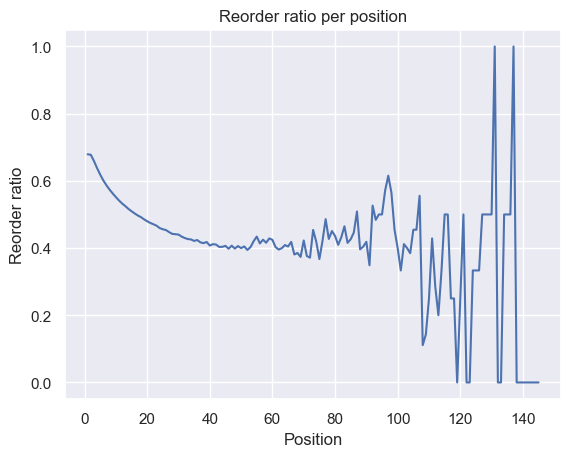

In [31]:
ax = sns.lineplot(x=position_reorders.index.astype(int), y=position_reorders['reorder_ratio'])
plt.title('Reorder ratio per position')
ax.set(xlabel='Position', ylabel='Reorder ratio')
plt.show()

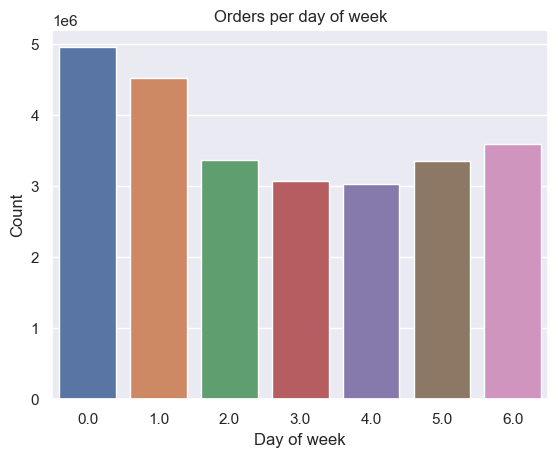

In [32]:
ax = sns.countplot(x='day_of_week', data=transaction_items.loc[~transaction_items['day_of_week'].isna()])
plt.title('Orders per day of week')
ax.set(xlabel='Day of week', ylabel='Count')
plt.show()

TypeError: reduction operation 'argmin' not allowed for this dtype

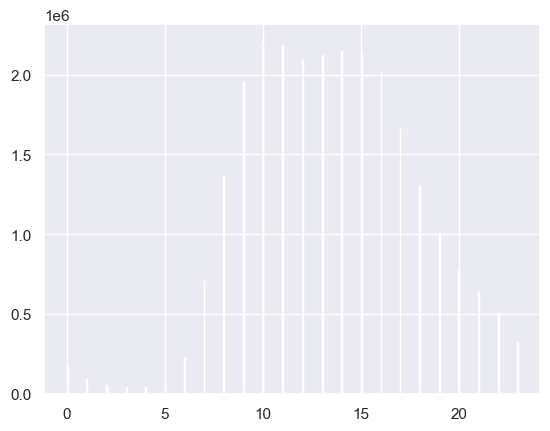

In [33]:
ax = sns.histplot(x='time_of_day', data=transaction_items.loc[~transaction_items['time_of_day'].isna()])
plt.title('Orders per time of day')
ax.set(xlabel='Time of day', ylabel='Count')
plt.show()